In [1]:
import sys
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation,BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
import pickle
import numpy as np
import cv2
import glob
import shutil
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Dataset Visulization

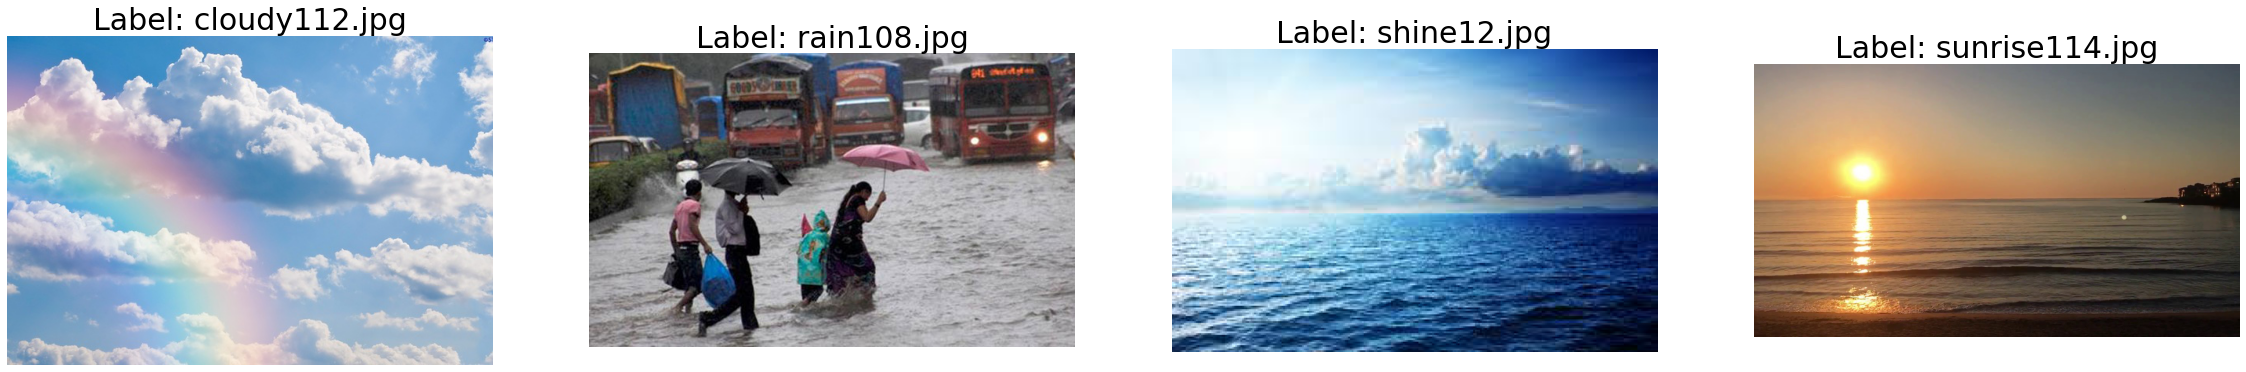

In [2]:
Images=['cloudy112.jpg','rain108.jpg','shine12.jpg','sunrise114.jpg']
plt.figure(figsize=(40,30))
place_img=0
for i in range(len(Images)):
    
    plt.subplot(1,4,place_img+1)
    plt.imshow(plt.imread('dataset2/'+Images[i]))
    plt.title('Label: '+Images[i].split('/')[0],fontsize=30)
    plt.axis('off')
    place_img=place_img+1
plt.show()

### Dataset Spliting

In [3]:
## New folder make
Dataset_folder='dataset/'
train_data_path = 'dataset/train/'
test_data_path = 'dataset/test/'

if not os.path.exists(Dataset_folder):
    os.makedirs(Dataset_folder)
if not os.path.exists(train_data_path):
    os.makedirs(train_data_path)
if not os.path.exists(test_data_path):
    os.makedirs(test_data_path)

In [4]:
Test_split=0.2 ## at 20% for test data

Classes=['cloudy', 'rain', 'shine', 'sunrise']
for category in Classes:
    All_images_category=glob.glob('dataset2/'+category+'*') #specific category all images
    np.random.seed(12)
#     print(len(All_images_category))
    np.random.shuffle(All_images_category)
    Train_images=All_images_category[int(len(All_images_category)*Test_split):]
    Test_images=All_images_category[:int(len(All_images_category)*Test_split)]
    print(category,'>     Train Images:',len(Train_images),' Test Images:',len(Test_images))
    train_folder_category=train_data_path+category
    if not os.path.exists(train_folder_category):
        os.makedirs(train_folder_category)# creating new folder of category in the train
    for image_path in Train_images:
        shutil.copy(image_path,os.path.join(train_folder_category,image_path.split('\\')[-1].split('/')[-1]))

    
    test_folder_category=test_data_path+category
    if not os.path.exists(test_folder_category):
        os.makedirs(test_folder_category)# creating new folder of category in the test
    for image_path in Test_images:
        shutil.copy(image_path,os.path.join(test_folder_category,image_path.split('\\')[-1].split('/')[-1]))


cloudy >     Train Images: 240  Test Images: 60
rain >     Train Images: 172  Test Images: 43
shine >     Train Images: 203  Test Images: 50
sunrise >     Train Images: 286  Test Images: 71


## Experimentation:

In [5]:
img_width, img_height = 128,128
batch_size = 2
lr = 0.001

In [6]:
"""
Parameters
"""

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                              target_size=(img_width,img_height),
                                              batch_size=batch_size,class_mode='categorical',shuffle = True,seed=1)


test_datagen = ImageDataGenerator(
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_data_path,
                                             target_size=(img_width,img_height),
                                             batch_size=batch_size,class_mode='categorical',shuffle = False,seed=1)

test_images_count = len(test_generator.filenames)

with open('classes_name.pickle', 'wb') as handle:
    pickle.dump(test_generator.class_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

Classes=list(test_generator.class_indices.keys())
Classes

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


['cloudy', 'rain', 'shine', 'sunrise']

In [7]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model

def VGG16(Input_shape=(224,224,3),No_classes=4):
    _input = Input(Input_shape) 

    Conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
    Conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(Conv1)
    pool1  = MaxPooling2D((2, 2))(Conv2)

    Conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
    Conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(Conv3)
    pool2  = MaxPooling2D((2, 2))(Conv4)

    Conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
    Conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(Conv5)
    Conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(Conv6)
    pool3  = MaxPooling2D((2, 2))(Conv7)

    Conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
    Conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(Conv8)
    Conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(Conv9)
    pool4  = MaxPooling2D((2, 2))(Conv10)

    Conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
    Conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(Conv11)
    Conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(Conv12)
    pool5  = MaxPooling2D((2, 2))(Conv13)

    flat   = Flatten()(pool5)
    dense1 = Dense(4096, activation="relu")(flat)
    dense2 = Dense(4096, activation="relu")(dense1)
    output = Dense(No_classes, activation="softmax")(dense2)

    vgg16_model  = Model(inputs=_input, outputs=output)
    return vgg16_model

In [8]:
VGG16_Model=VGG16(Input_shape=(img_width, img_height,3),No_classes=len(Classes))
VGG16_Model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [9]:
VGG16_Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0   

In [10]:
def get_callbacks_list():
    """Get callbacks for a model"""
    return [callbacks.EarlyStopping(monitor='val_accuracy',patience=25),
            callbacks.ReduceLROnPlateau(verbose=1,monitor='val_loss',factor=0.2,patience=10)]

In [11]:
train_steps = len(train_generator.filenames) // batch_size
test_steps = len(test_generator.filenames) // batch_size
history = VGG16_Model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_steps,
    callbacks=get_callbacks_list())


Epoch 1/100
450/450 [==============================] - 53s 117ms/step - loss: 1.3527 - accuracy: 0.3637 - val_loss: 1.2325 - val_accuracy: 0.4955
Epoch 2/100
450/450 [==============================] - 49s 109ms/step - loss: 1.1148 - accuracy: 0.4917 - val_loss: 0.0589 - val_accuracy: 0.5893
Epoch 3/100
450/450 [==============================] - 49s 108ms/step - loss: 0.9459 - accuracy: 0.5662 - val_loss: 0.7918 - val_accuracy: 0.6027
Epoch 4/100
450/450 [==============================] - 49s 108ms/step - loss: 0.8942 - accuracy: 0.6363 - val_loss: 0.0074 - val_accuracy: 0.7455
Epoch 5/100
450/450 [==============================] - 49s 108ms/step - loss: 0.7222 - accuracy: 0.6997 - val_loss: 0.1704 - val_accuracy: 0.7143
Epoch 6/100
450/450 [==============================] - 49s 108ms/step - loss: 0.7027 - accuracy: 0.6863 - val_loss: 0.0677 - val_accuracy: 0.7679
Epoch 7/100
450/450 [==============================] - 48s 108ms/step - loss: 0.6171 - accuracy: 0.7386 - val_loss: 3.2851e

450/450 [==============================] - 49s 109ms/step - loss: 0.1398 - accuracy: 0.9488 - val_loss: 5.4866e-04 - val_accuracy: 0.8482


### Model Save and load

Model is saved and to avoid training time, no need to train from start just load the model then start using it for testing.

In [12]:
VGG16_Model.save('VGG16_Model.h5')

In [18]:
# from keras.models import load_model
# VGG16_Model = load_model('VGG16_Model.h5')

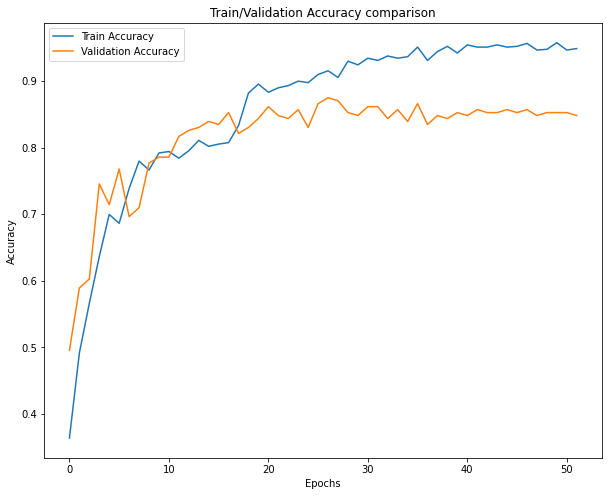

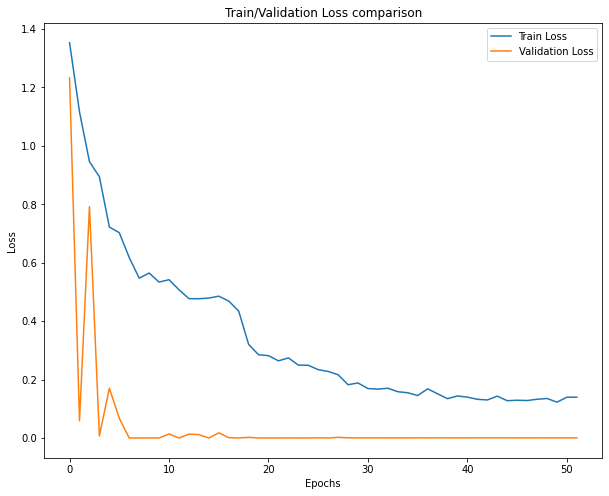

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,8])
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Train/Validation Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Train_Validation_Accuracy_comparison.png')
plt.show()

plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Train/Validation Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Train_Validation_Loss_comparison.png')
plt.show()

In [14]:
# test_generator.reset()

from sklearn.metrics import accuracy_score
predicted_labels = VGG16_Model.predict_generator(test_generator,test_steps,workers=1)
accuracy = accuracy_score(test_generator.labels, np.argmax(predicted_labels,axis=1)) * 100
accuracy

84.82142857142857

#### Classification Score and Confusion Metric

In [15]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.labels, np.argmax(predicted_labels,axis=1)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        60
           1       0.71      0.67      0.69        43
           2       0.90      0.90      0.90        50
           3       1.00      1.00      1.00        71

    accuracy                           0.85       224
   macro avg       0.83      0.83      0.83       224
weighted avg       0.85      0.85      0.85       224



In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd
print ("Confusion matrix")
pd.DataFrame(confusion_matrix(test_generator.labels,np.argmax(predicted_labels,axis=1)),columns=Classes,index=Classes)

Confusion matrix


cloudy  rain  shine  sunrise
cloudy       45    11      4        0
rain         13    29      1        0
shine         4     1     45        0
sunrise       0     0      0       71

#### Testing on Image

Predicted Category: sunrise


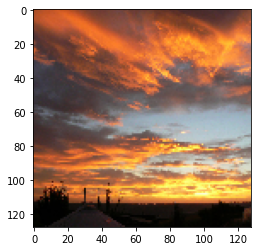

In [18]:
image_test = cv2.imread('dataset/test/sunrise/sunrise10.jpg')
image_test=cv2.cvtColor(image_test,cv2.COLOR_BGR2RGB)
image_test = cv2.resize(image_test,(img_width, img_height))

predicted_category=VGG16_Model.predict([(image_test/255.).reshape(1,img_width, img_height,3)])[0]
predicted_category=np.argmax(predicted_category)

plt.imshow(image_test)
print('Predicted Category:',Classes[predicted_category])

#### Wrong Classification Samples Visulization:

34


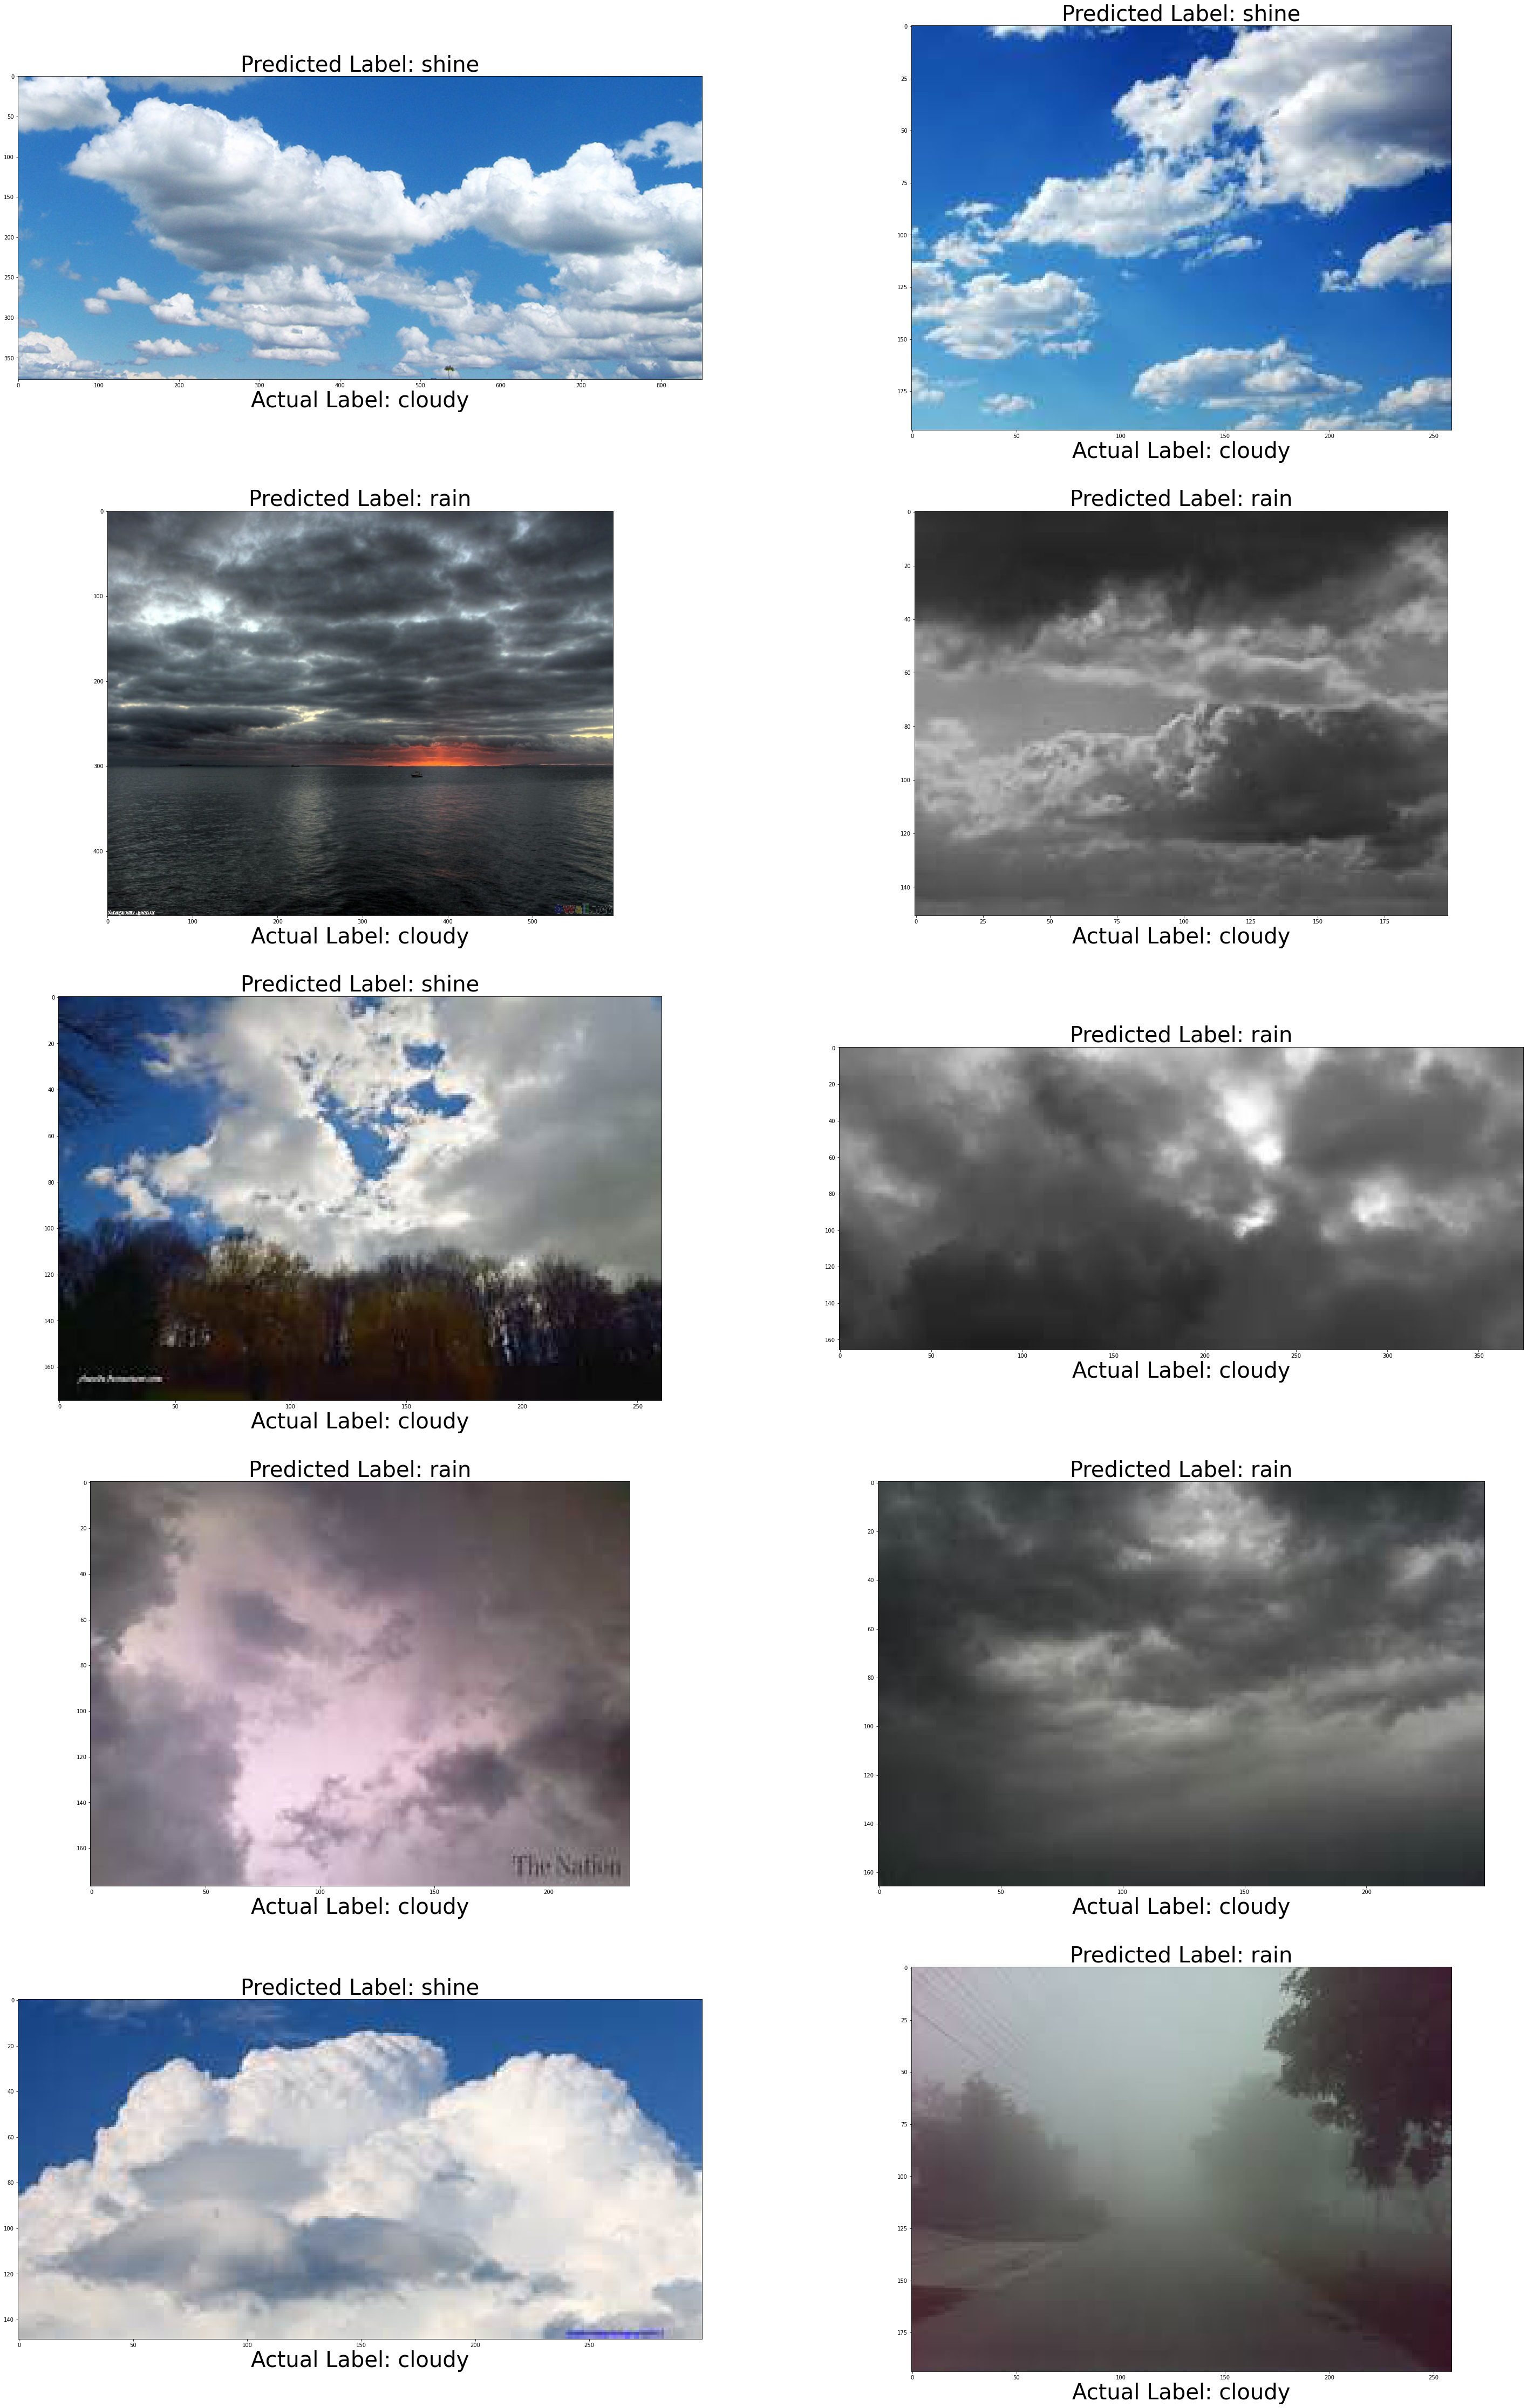

In [20]:
Wrong_classified_Examples=np.where(test_generator.labels!=np.argmax(predicted_labels,axis=1))[0]
print(len(Wrong_classified_Examples))
plt.figure(figsize=(50,80))
place_img=0
predicted_labels_n=np.argmax(predicted_labels,axis=1)
for index in Wrong_classified_Examples[:10]:
    
    plt.subplot(5,2,place_img+1)
    plt.imshow(plt.imread('dataset/test/'+test_generator.filenames[index]))
    plt.title('Predicted Label: '+Classes[predicted_labels_n[index]],fontsize=40)
    plt.xlabel('Actual Label: '+Classes[test_generator.labels[index]],fontsize=40)
#     plt.axis('off')
    place_img=place_img+1
plt.show()